United States market

Price to Cash flow from 10 to 20

In [109]:
import sys

import pandas
import sklearn
import sklearn.tree
import sklearn.cluster
import sklearn.preprocessing

sys.path.append('investpy')

import investpy
import random
import numpy as np
import scipy
import scipy.stats
import pandas_ta
import traceback

In [110]:
n = 50
index = 'NASDAQ'
country = "United States"
date_from = "01/09/2019"
date_to = "01/09/2020"

In [111]:
index_data = investpy.indices.get_index_historical_data(index, country, date_from, date_to)
correct_days = len(index_data)
print(f"Days in period: {correct_days}")

Days in period: 253


In [112]:
class StockData:
  def calculate_rsi(self, periods = 14, ema = True):
    close_delta = self.data.loc[:, 'Close'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

  def calculate_info(self):
    self.average = self.close.mean()
    self.abs_growth = self.close[-1] - self.close[0]
    self.rel_growth = self.abs_growth/self.close[0]
    self.abs_growth_to_rel_growth = self.abs_growth/self.rel_growth
    self.variance = self.close.std() / self.average
    self.range = self.close.max() - self.close.min()
    self.range_ln = np.log(self.range)
    self.oscillation = self.average / self.range

    self.stock_diff = np.array([(self.close[i]/self.close[i-1])-1 for i in range(1, len(self.close))])
    self.profit_avg = self.stock_diff.mean()
    self.profit_var = self.stock_diff.std()

    self.ratios = investpy.stocks.get_stock_ratios(self.stock, self.country)

    self.debt_to_equity = self.ratios["Total Debt to Equity"].to_numpy()[0]
    if np.isnan(self.debt_to_equity):
        raise ValueError("Debt to equity is nan")

    self.basic_eps = self.ratios["Basic EPS"].to_numpy()[0]
    if np.isnan(self.basic_eps):
        raise ValueError("Basic EPS is nan")

    self.pe_ratio = self.ratios["P/E Ratio"].to_numpy()[0]
    if np.isnan(self.pe_ratio):
        raise ValueError("Basic EPS is nan")

    self.dividend_yield = self.ratios["Dividend Yield"].to_numpy()[0]
    if np.isnan(self.dividend_yield):
        raise ValueError("Dividend Yeild is nan")

    self.current_ratio = self.ratios["Current Ratio"].to_numpy()[0]
    if np.isnan(self.current_ratio):
        raise ValueError("Current Ratio is nan")

    self.roe = self.ratios["Return on Equity"].to_numpy()[0]
    if np.isnan(self.roe):
        raise ValueError("Return on Equity is nan")


    self.rsi = pandas_ta.rsi(self.data['Close'], length = correct_days-1).iloc[-1]
    self.volatility = self.close.std()

    self.beta = np.cov([portfolio_close, index_data['Close'].to_numpy()])[0][1]/np.std(index_data['Close'].to_numpy())

    # index_data.loc[:, 'Close'].to_numpy()

    self.spearman = scipy.stats.spearmanr(self.close, list(range(len(self.close)))).correlation
    # stability of quotes to2810.xlsx candles (22)
    # делаем линейную регрессию, считаем квадраты отклонений от неё, stability of quoates = 1 - среднеквадратичное отклонение / сумму квадратов отклонений

    # stability = среднее положительных приростов / среднеее отрицательных приростов
    # rsi = количество положительных приростов / количество отрицательных приростов

  def __init__(self, stock, country, date_from, date_to, data):
    self.stock = stock
    self.country = country
    self.date_from = date_from
    self.date_to = date_to
    self.data = data
    self.close = data.loc[:, 'Close'].to_numpy()
    self.calculate_info()

  def __repr__(self):
    return f"""
stock: {self.stock},
country: {self.country},
date_from: {self.date_from},
date_to: {self.date_to},
data: 
{self.data.head()}"""

In [113]:
def get_stock_historical_data(stock,
                              country,
                              from_date,
                              to_date):
  df = investpy.get_stock_historical_data(stock=stock,
                                          country=country,
                                          from_date=from_date,
                                          to_date=to_date,
                                          order='ascending',
                                          interval="Daily")
  return df.loc[:, ['Open', 'High', 'Low', 'Close']]

In [114]:
def get_random_stock_data_n(n, countries, date_from, date_to, correct_days, debug=False):
  stocks = []
  for country in countries:
    country_stocks = investpy.get_stocks_list(country)
    country_stocks = list(filter(lambda s: not s.endswith("_p"), country_stocks)) # _p is privileged stock
    country_stocks = zip(country_stocks, [country] * len(country_stocks))
    stocks += country_stocks
  random.shuffle(stocks)
  stock_data = []
  for (stock, country) in stocks:
    try:
      data = get_stock_historical_data(stock, country, date_from, date_to)
      stock_datum = StockData(stock, country, date_from, date_to, data)
      if len(stock_datum.close) != correct_days:
        continue
#       if stock_datum.profit_avg < 0:
#         continue
      stock_data.append(stock_datum)
      print(f"{len(stock_data)}/{n}")
    except Exception as e:
      if debug:
          traceback.print_exc()
        # print(e)
      # possibly, not available in selected date interval
    if len(stock_data) >= n:
      break
  return stock_data

In [115]:
def get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=False):
    stock_data = []
    for stock in selected_stocks:
        try:
            data = get_stock_historical_data(stock, country, date_from, date_to)
            if len(data.loc[:, 'Close']) != correct_days:
                continue
            stock_datum = StockData(stock, country, date_from, date_to, data)
            stock_data.append(stock_datum)
            print(f"{len(stock_data)}/{n}")
        except Exception as e:
            if debug:
                traceback.print_exc()
            # possibly, not available in selected date interval
        if len(stock_data) >= n:
            break
    return stock_data

In [116]:
def get_stock_data(method: str = 'screener', debug=False):
    if method == 'random':
        stock_data = get_random_stock_data_n(n, [country], date_from, date_to, correct_days, debug=debug)
    elif method == 'screener':
        selected_stocks_df = investpy.screener(
            investpy.ScreenerParams()
                .with_country(country)
                .add_filter("Price to Cash Flow (MRQ)", 10, 20),
            as_dataframe=True, n_results=300)
        selected_stocks = selected_stocks_df['symbol'].to_numpy()
        selected_stocks = list(set(selected_stocks))
        stock_data = get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=debug)
    else:
        raise ValueError(f"Unexpected method {method}")
    print(f"Selected {len(stock_data)} stocks: {list(map(lambda x: x.stock, stock_data))}")

    return stock_data

In [117]:
stock_data = get_stock_data('screener', debug=False)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
Selected 50 stocks: ['RDSa', 'TS', 'HNNA', 'GEFb', 'ORAN', 'AMGN', 'BHE', 'MT', 'RCKY', 'IBA', 'HCMLY', 'AROC', 'FUL', 'BGS', 'ALSN', 'AGCO', 'EC', 'NWL', 'BWA', 'CTSH', 'WBRBY', 'CEO', 'BCEI', 'ALG', 'NTTYY', 'ASTE', 'COKE', 'SSL', 'ERIC', 'RS', 'BTI', 'ATHM', 'ALV', 'T', 'AIR', 'BBL', 'APOG', 'NWSA', 'TELNY', 'AIMC', 'ODC', 'CBRL', 'AY', 'SAH', 'ACCO', 'B', 'HMC', 'WBA', 'BRDCY', 'GFI']


In [145]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

def markovitz_optimization(selected_stock_data):
    labels =      list(map(lambda x: x.stock, selected_stock_data))
    mu = np.array(list(map(lambda x: 100*x.profit_avg, selected_stock_data)))

    var = np.array(list(map(lambda x: x.profit_var, selected_stock_data)))

    R = np.corrcoef(np.array(list(map(lambda x: x.stock_diff, selected_stock_data))))

    var = np.expand_dims(var, axis=0)
    S = var.T @ var * R
    # Initial guess
    x = np.ones(len(labels)) * (1/len(labels))

    def value(x):
            return x.T @ S @ x

    def optimize_portfolio(r):
        mu_cons = {'type': 'eq',
                     'fun': lambda x: np.sum(mu @ x.T) - r
                    }
        sum_cons = {'type': 'eq',
                     'fun': lambda x: np.sum(x) - 1
                    }
        bnds = Bounds (np.ones_like(x) * 0.0, np.ones_like(x))

        res = minimize(value, x, method='SLSQP',
                       constraints=[mu_cons, sum_cons], bounds=bnds)
        return res

    rate = np.linspace(0, 1, 100)
    opti = list(map(optimize_portfolio, rate))
    y = np.array(list(map(lambda res: res.x, opti))).T

    plt.figure(figsize=(40, 16))
    plt.stackplot(rate, y, labels=labels)
    plt.legend(loc='upper left')
    plt.show()

    opti_vars = list(map(lambda res: res.fun, opti))
    plt.figure(figsize=(16, 6))
    plt.plot(opti_vars, rate)
    plt.xlabel('Risk')
    plt.ylabel('Profit')
    plt.show()

    risks = np.zeros_like(rate, dtype=np.float64)
    profits = np.zeros_like(rate, dtype=np.float64)
    betas = np.zeros_like(rate, dtype=np.float64)

    for (i, optimal) in enumerate(opti):
        profit = np.sum(mu @ optimal.x.T)
        risk = optimal.fun

        portfolio_close = np.zeros_like(selected_stock_data[0].close)
        for (j, stock) in enumerate(selected_stock_data):
            portfolio_close += optimal.x[j] * stock.close

        portfolio_beta = np.cov([portfolio_close, index_data['Close'].to_numpy()])[0][1]/np.std(index_data['Close'].to_numpy())

        risks[i] = risk
        profits[i] = profit
        betas[i] = portfolio_beta

    plt.figure(figsize=(12, 8))
    plt.plot(profits, risks)
    plt.xlabel('Profit')
    plt.ylabel('Portfolio risk')
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(profits, betas)
    plt.xlabel('Profit')
    plt.ylabel('Portfolio beta')
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(risks, betas)
    plt.xlabel('Portfolio risk')
    plt.ylabel('Beta')
    plt.show()

    return rate, opti

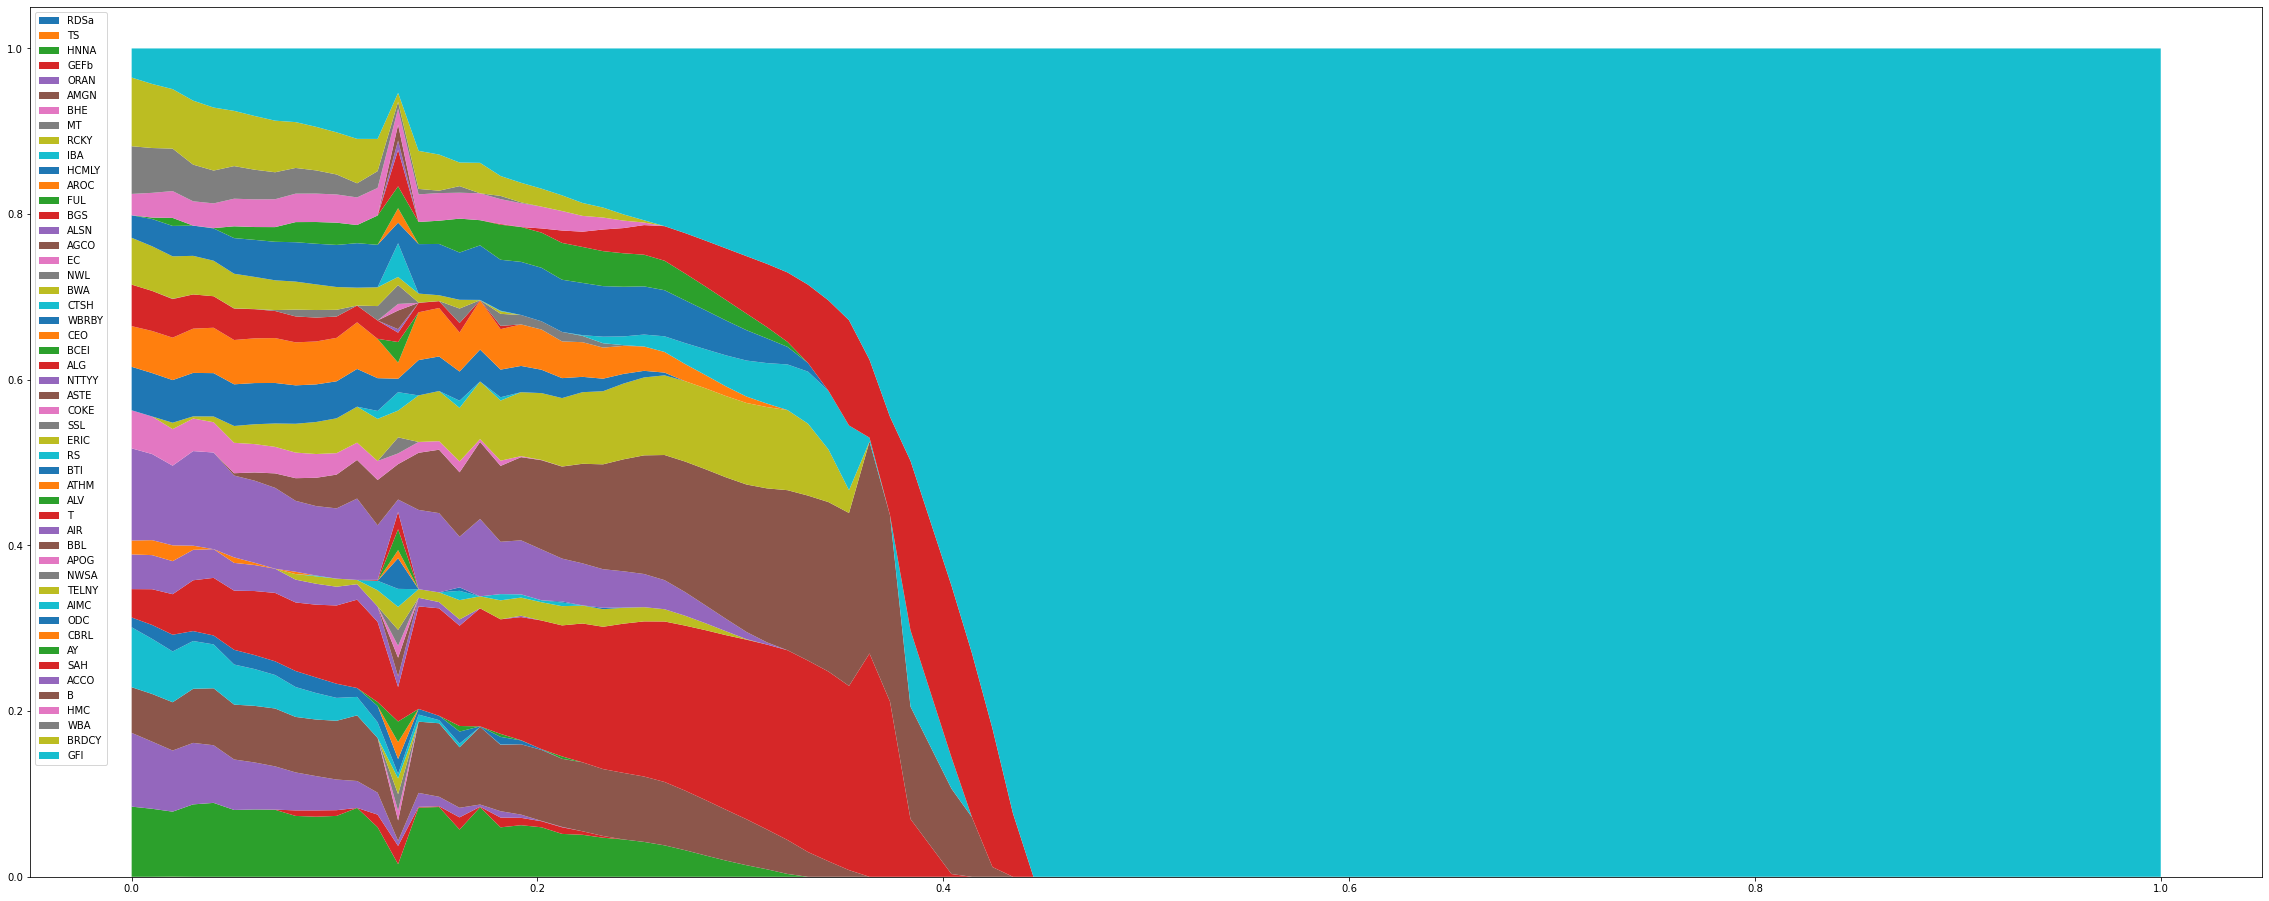

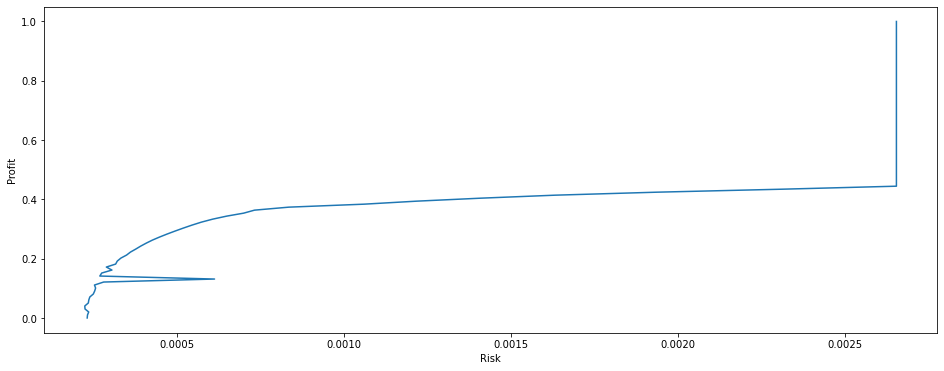

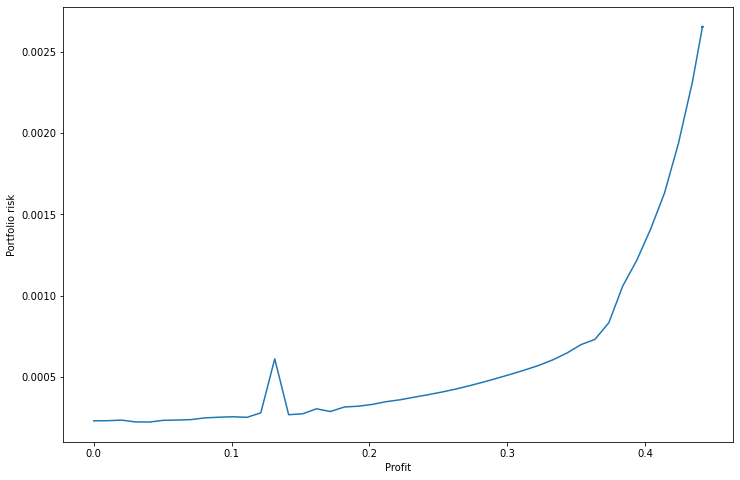

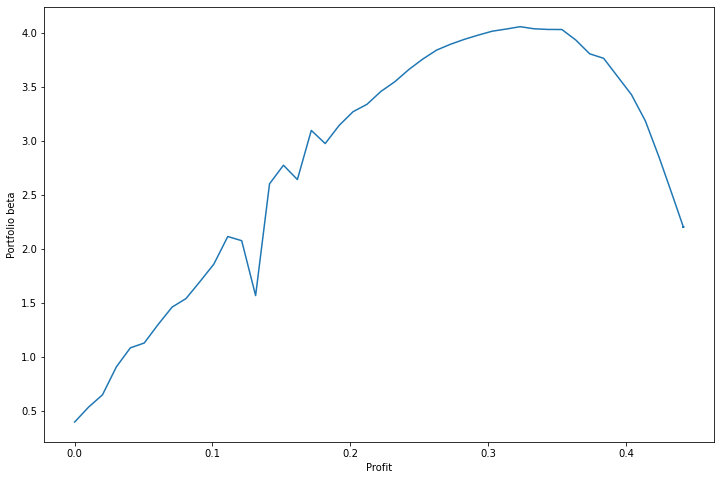

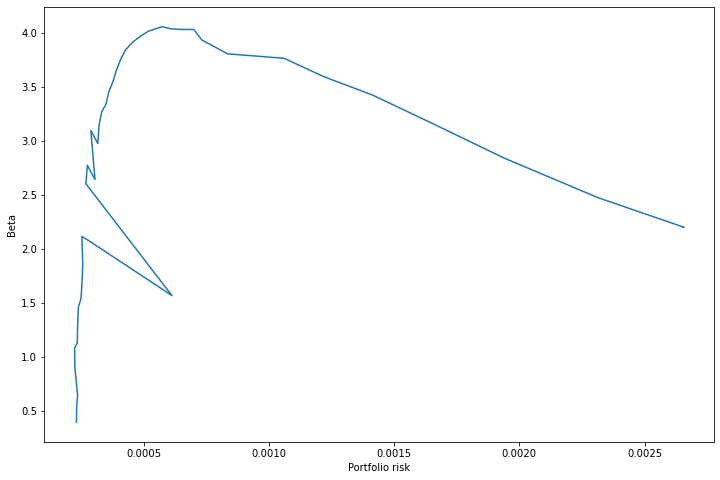

In [140]:
rate, opti = markovitz_optimization(stock_data)
print()

In [150]:
def portfolio_by_profit_rate(selected_stock_data, rate, opti, profit_rate):
    labels =      list(map(lambda x: x.stock, selected_stock_data))
    mu = np.array(list(map(lambda x: 100*x.profit_avg, selected_stock_data)))

    idx = np.argmax(rate >= profit_rate)
    optimal = opti[idx]

    profit = np.sum(mu @ optimal.x.T)
    risk = optimal.fun

    print(f"Risk: {risk}")
    print(f"Average daily profit: {profit}")

    portfolio_close = np.zeros_like(selected_stock_data[0].close)
    for (i, stock) in enumerate(selected_stock_data):
        portfolio_close += optimal.x[i] * stock.close

    portfolio_beta = np.cov([portfolio_close, index_data['Close'].to_numpy()])[0][1]/np.std(index_data['Close'].to_numpy())
    print(f"Beta: {portfolio_beta}")
    print()

    for (i, lab) in enumerate(labels):
        print(f"{lab}: \t\t{optimal.x[i]}")

    fig1, ax1 = plt.subplots(figsize=(18, 12))
    only_notnull = optimal.x > 1e-4
    ax1.pie(optimal.x[only_notnull]*100, labels=np.array(labels)[only_notnull], autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    ax1.set_title(f"Portfolio with profit {profit}, risk {risk}")
    plt.show()

Risk: 0.00023330503624114415
Average daily profit: 0.050505050506627555
Beta: 1.1267048763196648

RDSa: 		0.0
TS: 		0.0
HNNA: 		0.08068261416224844
GEFb: 		3.2526065174565133e-18
ORAN: 		0.06095604046004499
AMGN: 		0.06623510180597857
BHE: 		0.0
MT: 		1.7095509656129459e-19
RCKY: 		0.0
IBA: 		0.04839756912627103
HCMLY: 		0.017757366367636723
AROC: 		4.532080421218312e-19
FUL: 		0.0
BGS: 		0.07140166495129555
ALSN: 		0.03354095834974346
AGCO: 		0.0
EC: 		2.904713067150214e-19
NWL: 		0.0
BWA: 		5.608940072086011e-18
CTSH: 		4.6353485164556205e-18
WBRBY: 		1.7063853160693907e-18
CEO: 		0.00665828900515857
BCEI: 		1.641339992349152e-19
ALG: 		0.0
NTTYY: 		0.09877733217865091
ASTE: 		0.0028167760621094127
COKE: 		0.036696319180092786
SSL: 		4.273604350887096e-19
ERIC: 		0.020315608202850402
RS: 		2.9182414005925383e-18
BTI: 		0.050310157639099747
ATHM: 		0.05348304995831581
ALV: 		0.0
T: 		0.03792524372767203
AIR: 		1.996863737228742e-18
BBL: 		0.0
APOG: 		0.0
NWSA: 		0.00030669436667540287

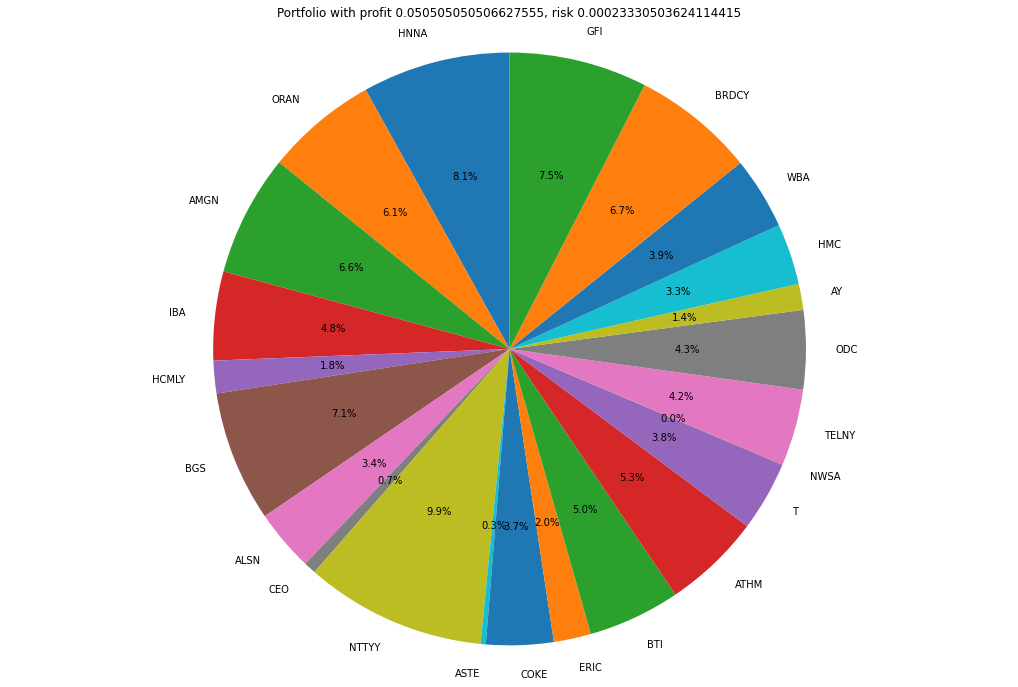

In [142]:
portfolio_by_profit_rate(stock_data, rate, opti, 0.05)

In [127]:
def to_ndarray_invest(stock_data):
    features = []
    features.append(list(map(lambda x: x.beta, stock_data)))
    features.append(list(map(lambda x: x.debt_to_equity, stock_data)))
    features.append(list(map(lambda x: x.dividend_yield, stock_data)))
    features.append(list(map(lambda x: x.current_ratio, stock_data)))
    features.append(list(map(lambda x: x.roe, stock_data)))
    return np.array(features).T

def to_ndarray_trade(stock_data):
    features = []
    # features.append(list(map(lambda x: x.range_ln, stock_data)))
    features.append(list(map(lambda x: x.rsi, stock_data)))
    features.append(list(map(lambda x: x.volatility, stock_data)))
    features.append(list(map(lambda x: x.oscillation, stock_data)))
    features.append(list(map(lambda x: x.pe_ratio, stock_data)))
    return np.array(features).T

In [128]:
def get_correlation(data, high_coef=0.8):
    coercoef = np.corrcoef(data.T)
    for (i, row) in enumerate(coercoef):
        for (j, val) in enumerate(row):
            if i < j and abs(val) >= high_coef:
                print('High correlation detected for features {} and {}'.format(i, j))
    return coercoef

In [129]:
def draw_boxplot(X, labels, colors=None):
    # X[i] -- фичи для акции i
    # label[i] -- номер кластера акции i
    # X.shape = (#stocks, #features)

    fig, ax = plt.subplots(figsize=(10, 7))
    legend1, legend2 = [], []
    for label in range(1, max(labels) + 1):
        my = X[np.where(labels == label)]
        if colors is None:
            clr = list(np.random.random(3))
            clr2 = list(np.random.random(3))
        else:
            clr  = colors[label-1][0]
            clr2 = colors[label-1][1]
        bp = ax.boxplot(my, patch_artist=True)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=clr)
        for patch in bp['boxes']:
            patch.set(facecolor=clr2)
        legend1.append(bp["boxes"][0])
        legend2.append('Cluster ' + str(label-1))
    ax.legend(legend1, legend2)
    # plt.ylim(0, 1)
    plt.show()

In [130]:
def index_by_stock_data(stock_data_closes):
    # closes = []
    # for i in stock_data:
    #     closes.append(i.close)
    return scipy.stats.mstats.gmean(np.array(stock_data_closes))

In [131]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

def best_representative_of_cluster(stock_data, labels):
    stock_data_closes = []
    for stock_datum in stock_data:
        stock_data_closes.append(stock_datum.close)
    stock_data_closes = np.array(stock_data_closes)

    best_of_cluster = []
    for label in range(1, max(labels)+1):
        global_indices = np.array(list(range(len(stock_data))))[np.where(labels == label)]
        stock_data_closes_in_cluster = stock_data_closes[np.where(labels == label)]
        print("Cluster {}: {}".format(label, ' '.join(np.array(list(map(lambda x: x.stock, stock_data)))[np.where(labels == label)])))

        index_in_cluster = index_by_stock_data(stock_data_closes_in_cluster)

        x = np.ones(len(stock_data_closes_in_cluster)) * (1/len(stock_data_closes_in_cluster))

        def value(x):
            return (stock_data_closes_in_cluster.T @ x - index_in_cluster).std()

        sum_cons = {'type': 'eq',
                     'fun': lambda x: np.sum(x) - 1
                    }
        bnds = Bounds (np.zeros_like(x), np.ones_like(x))

        opti = minimize(value, x, method='SLSQP', constraints=[sum_cons], bounds=bnds)

        best_of_cluster.append((global_indices[np.argmax(opti.x)], np.max(opti.x)))
    return best_of_cluster

In [148]:
from scipy.cluster.hierarchy import dendrogram, linkage


def make_analysis(stock_data_features):
    print("Correlation between features")
    print(get_correlation(stock_data_features))

    sc = sklearn.preprocessing.StandardScaler()
    sc.fit(stock_data_features)
    stock_data_features_normalized = sc.transform(stock_data_features)

    methods = ['single', 'ward', 'complete', 'average', 'weighted', 'centroid', 'median']
    metrics =  ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
                'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
                'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
                'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
                'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

    def labels_by_linked(linked, n_clusters):
        return scipy.cluster.hierarchy.fcluster(linked, t=n_clusters, criterion='maxclust')

    all_labels = []
    need_to_markovitz = [False, True, False]

    for (indx, (method, metric)) in enumerate([('ward', 'euclidean'), ('complete', 'correlation'), ('average', 'braycurtis')]):
        linked = linkage(stock_data_features_normalized, method=method, metric=metric, optimal_ordering=True)

        labelList = range(0, len(stock_data_features_normalized))

        plt.figure(figsize=(10, 7))
        dendrogram(linked,
                    orientation='top',
                    labels=labelList,
                    distance_sort='descending',
                    show_leaf_counts=True)
        plt.title('{}, {}'.format(method, metric))
        plt.show()

        for n_clusters in range(2, 7):
            labels = labels_by_linked(linked, n_clusters)
            silhouette = sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric=metric)
            print('Method {}, Metric {}, Number of clusters {}, Silhouette {}'.format(method, metric, n_clusters, silhouette))

        labels = labels_by_linked(linked, 6)
        all_labels.append(labels)
        # colors = [('tan', 'red'), ('blue', 'black'), ('green', 'cyan')]
        draw_boxplot(stock_data_features_normalized, labels)
        tree = sklearn.tree.DecisionTreeClassifier()
        tree.fit(stock_data_features, labels)
        plt.figure(figsize=(18, 12))
        sklearn.tree.plot_tree(tree, fontsize=10)
        best_of_cluster = best_representative_of_cluster(stock_data, labels)
        best_stocks = []
        print('Best representatives of clusters')
        for (label, (i, coef)) in enumerate(best_of_cluster):
            print('Cluster {}: {} with coefficient {}'.format(label, stock_data[i].stock, coef))
            best_stocks.append(stock_data[i])

        if need_to_markovitz[indx]:
            rate, opti = markovitz_optimization(best_stocks)
            portfolio_by_profit_rate(best_stocks, rate, opti, 0.05)

        print('-'*100)
        print()
        print()

    similiarity_scores = np.zeros((len(all_labels), len(all_labels)))
    for (i, l1) in enumerate(all_labels):
        for (j, l2) in enumerate(all_labels):
            similiarity_scores[i][j] = sklearn.metrics.homogeneity_score(l1, l2)
    print(similiarity_scores)

Investment portfolio
Correlation between features
[[ 1.00000000e+00 -1.91911406e-18  2.53309412e-16 -3.37430147e-16
  -2.06834281e-16]
 [-1.91911406e-18  1.00000000e+00  2.18420467e-01 -2.80846136e-01
   3.59191485e-01]
 [ 2.53309412e-16  2.18420467e-01  1.00000000e+00 -2.38376834e-01
   5.76578964e-02]
 [-3.37430147e-16 -2.80846136e-01 -2.38376834e-01  1.00000000e+00
   1.54845085e-01]
 [-2.06834281e-16  3.59191485e-01  5.76578964e-02  1.54845085e-01
   1.00000000e+00]]


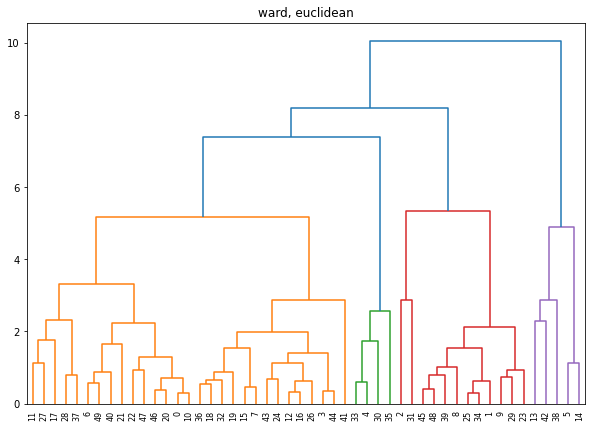

Method ward, Metric euclidean, Number of clusters 2, Silhouette 0.4605355569159707
Method ward, Metric euclidean, Number of clusters 3, Silhouette 0.24603037711727604
Method ward, Metric euclidean, Number of clusters 4, Silhouette 0.2752071923715215
Method ward, Metric euclidean, Number of clusters 5, Silhouette 0.23192326204452104
Method ward, Metric euclidean, Number of clusters 6, Silhouette 0.25233922114690055


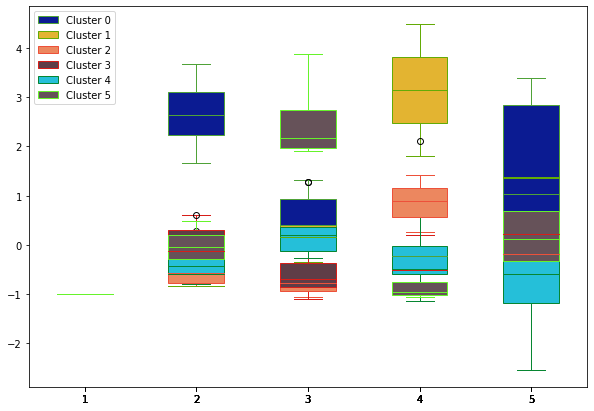

Cluster 1: AMGN BGS ALSN TELNY AY
Cluster 2: HNNA ATHM
Cluster 3: TS RCKY IBA ALG ASTE RS AIR AIMC B BRDCY
Cluster 4: GEFb MT FUL AGCO EC BWA CTSH NTTYY COKE ALV APOG CBRL SAH ACCO
Cluster 5: RDSa BHE HCMLY AROC NWL WBRBY CEO BCEI SSL ERIC NWSA ODC HMC WBA GFI
Cluster 6: ORAN BTI T BBL
Best representatives of clusters
Cluster 0: BGS with coefficient 0.38561194010770167
Cluster 1: HNNA with coefficient 0.8361958090527892
Cluster 2: TS with coefficient 0.19611912682680538
Cluster 3: EC with coefficient 0.22591649102548458
Cluster 4: GFI with coefficient 0.24085406837252313
Cluster 5: ORAN with coefficient 0.3614465453875708
----------------------------------------------------------------------------------------------------




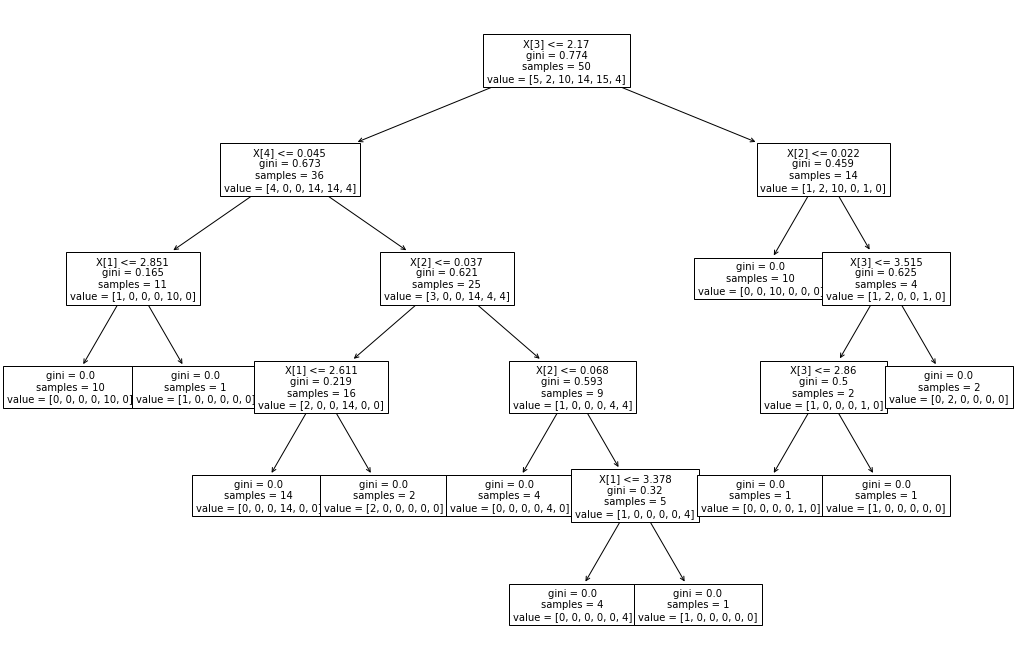

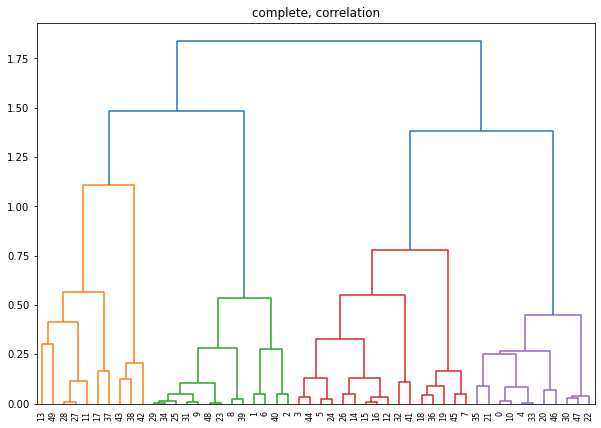

Method complete, Metric correlation, Number of clusters 2, Silhouette 0.29484205016557474
Method complete, Metric correlation, Number of clusters 3, Silhouette 0.3056955650109643
Method complete, Metric correlation, Number of clusters 4, Silhouette 0.507512578143752
Method complete, Metric correlation, Number of clusters 5, Silhouette 0.4830654170197637
Method complete, Metric correlation, Number of clusters 6, Silhouette 0.45436640261231787


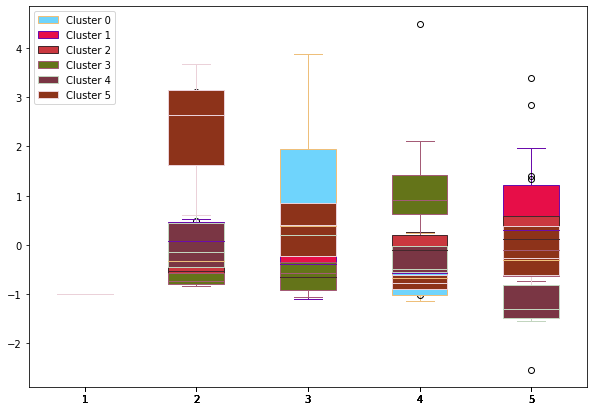

Cluster 1: RDSa ORAN HCMLY WBRBY CEO BCEI BTI T BBL HMC WBA
Cluster 2: GEFb AMGN FUL ALSN AGCO EC NTTYY COKE ALV CBRL ACCO
Cluster 3: MT BWA CTSH APOG B
Cluster 4: TS HNNA BHE RCKY IBA ALG ASTE RS ATHM AIR AIMC ODC BRDCY
Cluster 5: AROC BGS NWL SSL ERIC NWSA GFI
Cluster 6: TELNY AY SAH
Best representatives of clusters
Cluster 0: WBRBY with coefficient 0.30747852491118904
Cluster 1: EC with coefficient 0.32948862530008
Cluster 2: MT with coefficient 0.2527996254394246
Cluster 3: BRDCY with coefficient 0.1698100352648641
Cluster 4: GFI with coefficient 0.2651757948269947
Cluster 5: TELNY with coefficient 0.44887283814236284


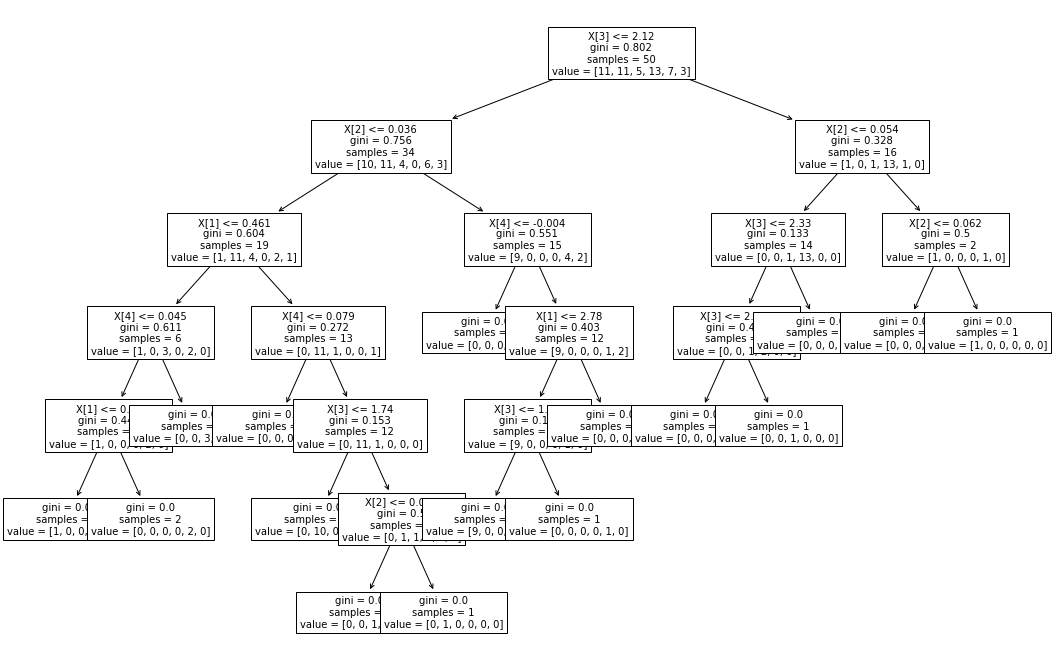

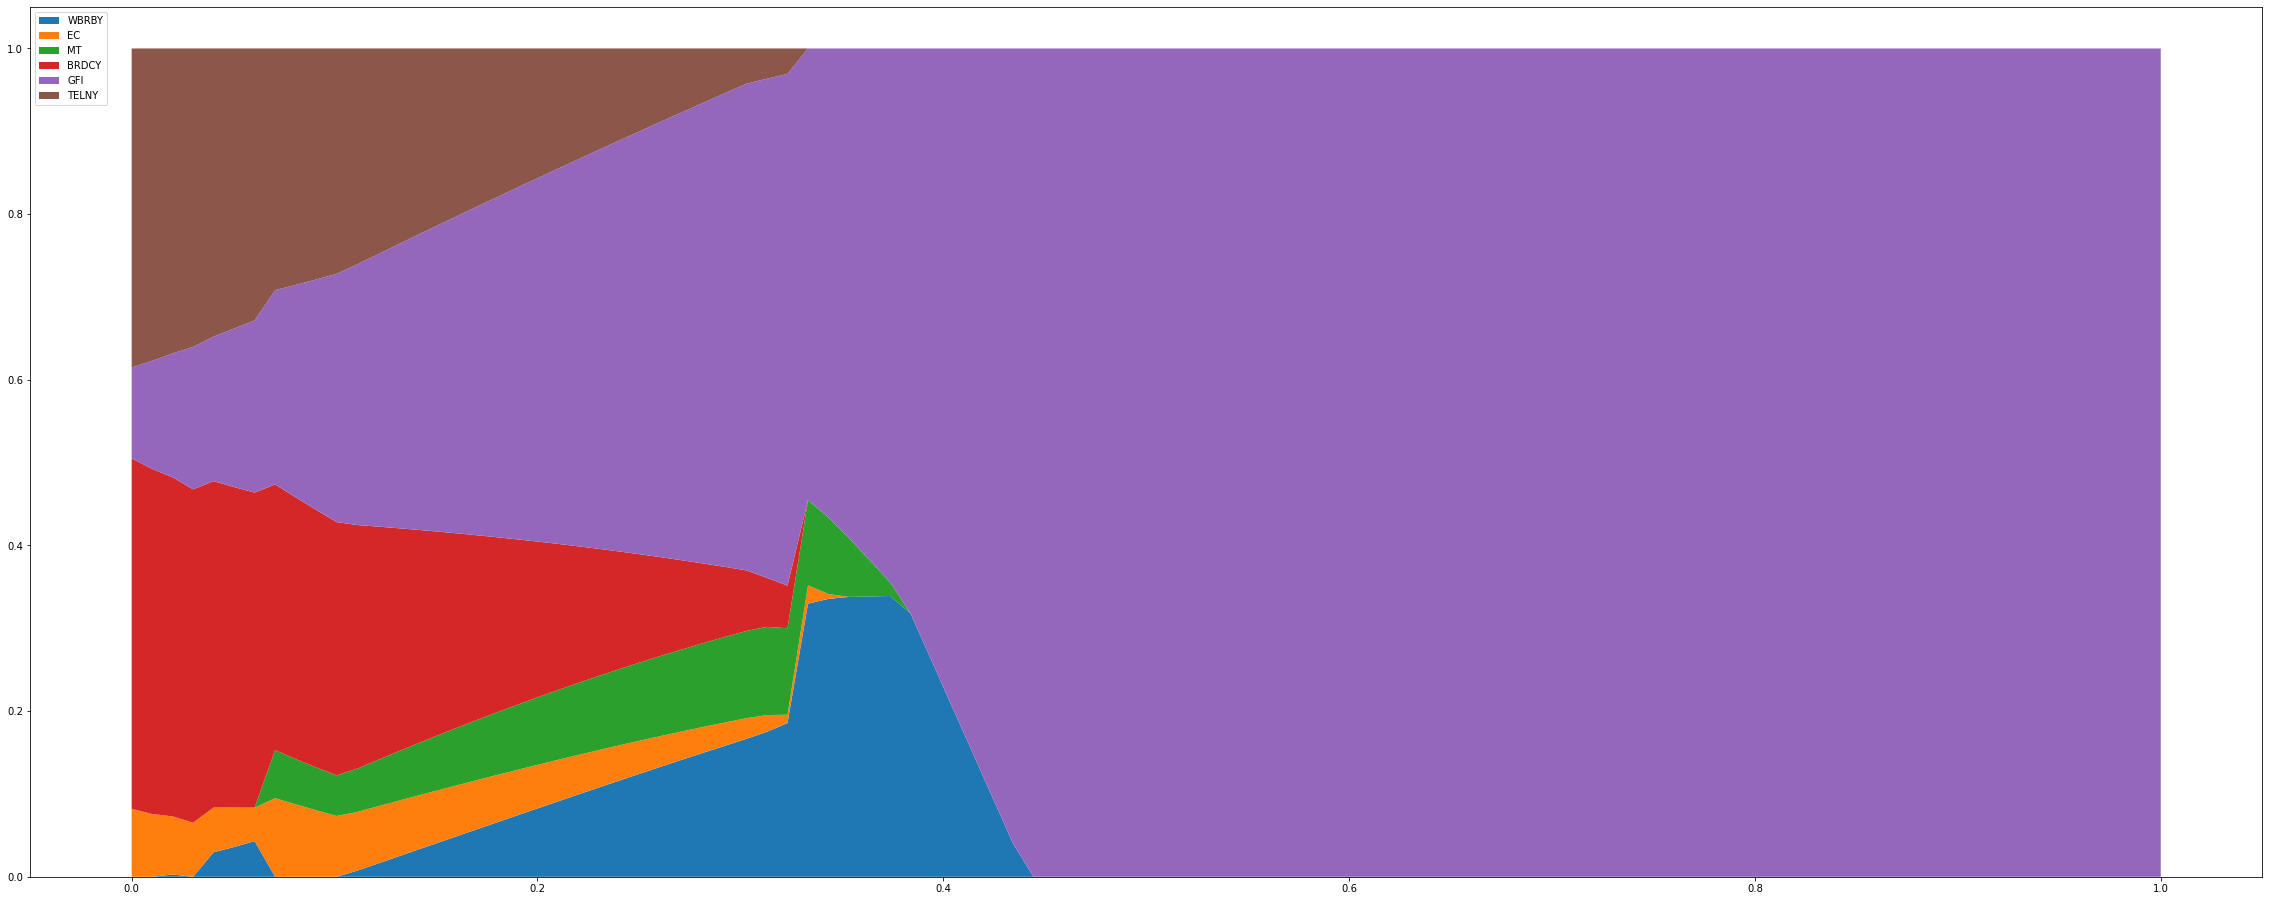

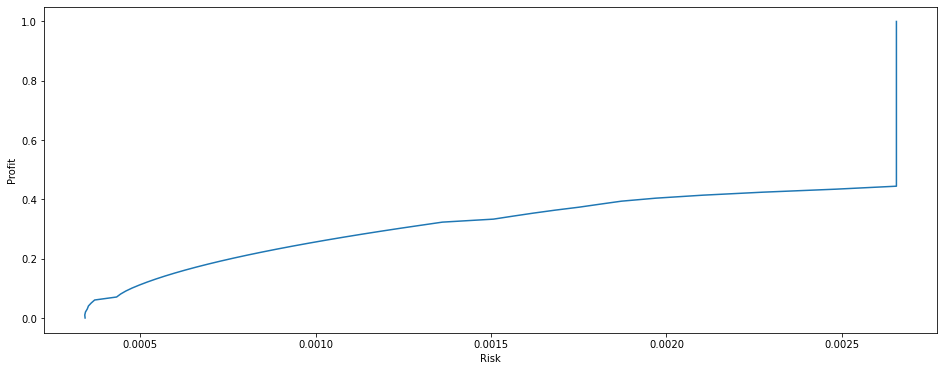

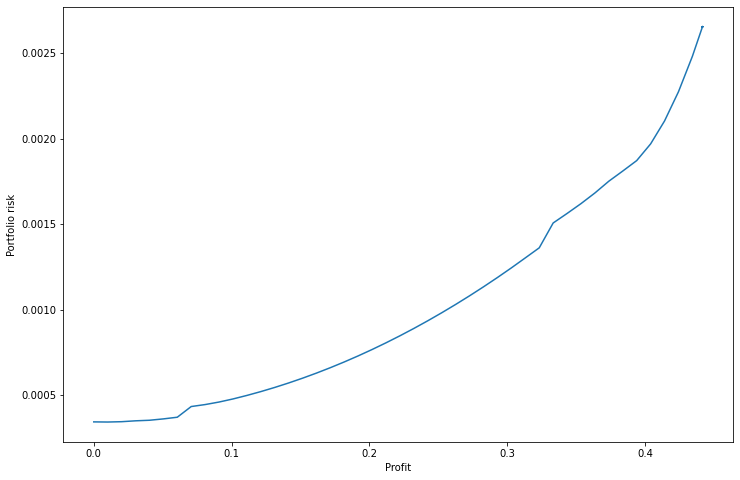

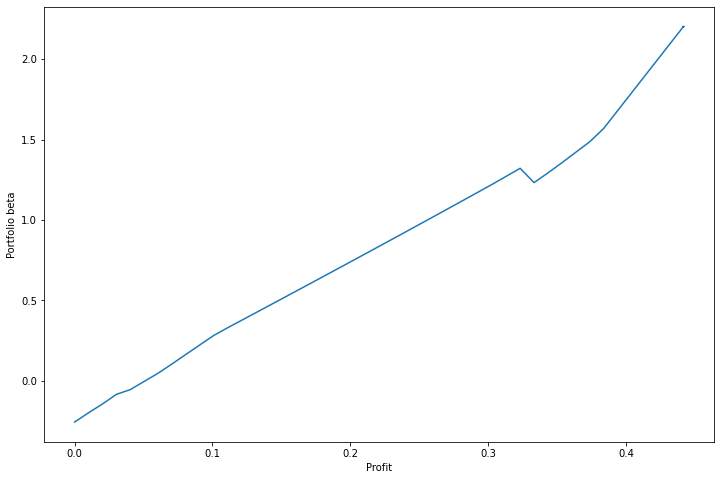

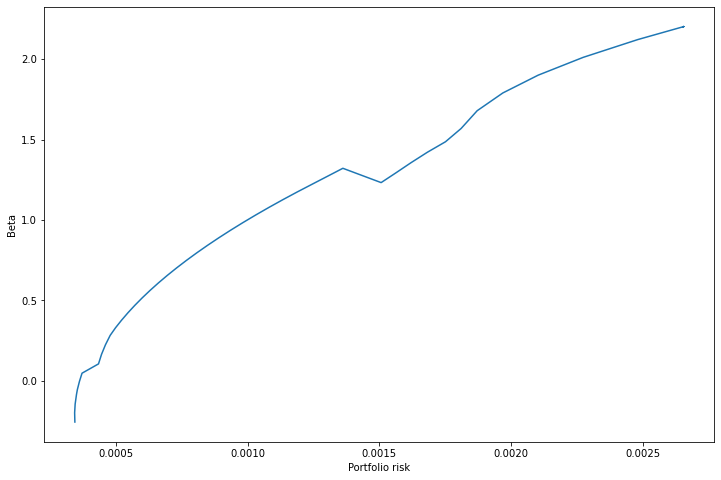

Risk: 0.0003607664680171961
Average daily profit: 0.050505050504387014
Beta: -0.003189558948085293

WBRBY: 		0.03594111578409025
EC: 		0.04763712722520254
MT: 		4.336808689942018e-19
BRDCY: 		0.3869094275371562
GFI: 		0.1913608090286878
TELNY: 		0.3381515204248633


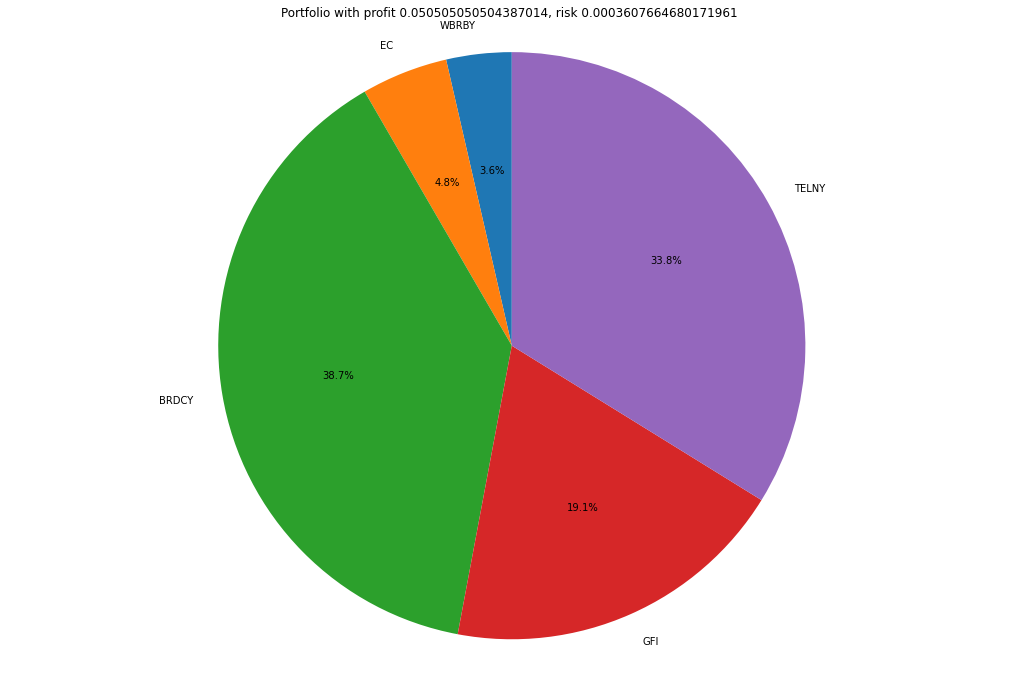

----------------------------------------------------------------------------------------------------




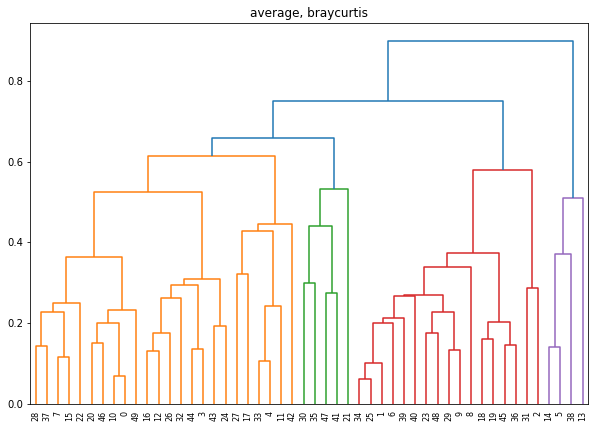

Method average, Metric braycurtis, Number of clusters 2, Silhouette 0.2953528096190084
Method average, Metric braycurtis, Number of clusters 3, Silhouette 0.28755086298684135
Method average, Metric braycurtis, Number of clusters 4, Silhouette 0.2669540046719245
Method average, Metric braycurtis, Number of clusters 5, Silhouette 0.27384256718763483
Method average, Metric braycurtis, Number of clusters 6, Silhouette 0.2632681637186907


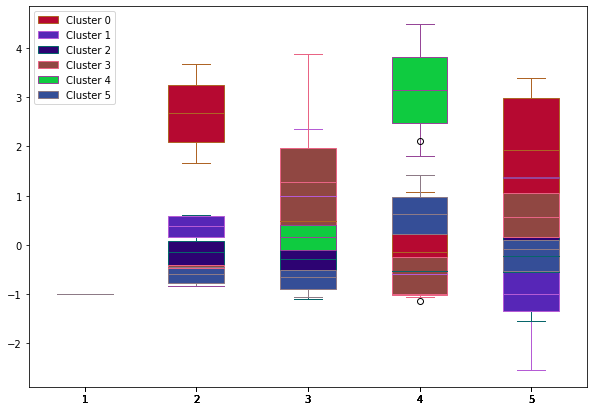

Cluster 1: AMGN BGS ALSN TELNY
Cluster 2: ORAN AROC NWL SSL T AY
Cluster 3: RDSa GEFb MT HCMLY FUL AGCO EC WBRBY BCEI NTTYY COKE ERIC ALV NWSA SAH ACCO HMC GFI
Cluster 4: CEO BTI BBL CBRL WBA
Cluster 5: HNNA ATHM
Cluster 6: TS BHE RCKY IBA BWA CTSH ALG ASTE RS AIR APOG AIMC ODC B BRDCY
Best representatives of clusters
Cluster 0: BGS with coefficient 0.5068842308911393
Cluster 1: SSL with coefficient 0.34366130742125106
Cluster 2: EC with coefficient 0.19491449391649382
Cluster 3: BTI with coefficient 0.29023603589707697
Cluster 4: HNNA with coefficient 0.8361958090527892
Cluster 5: TS with coefficient 0.13399038156457943
----------------------------------------------------------------------------------------------------


[[1.         0.61882691 0.54240253]
 [0.58581621 1.         0.4620668 ]
 [0.5621012  0.50583093 1.        ]]


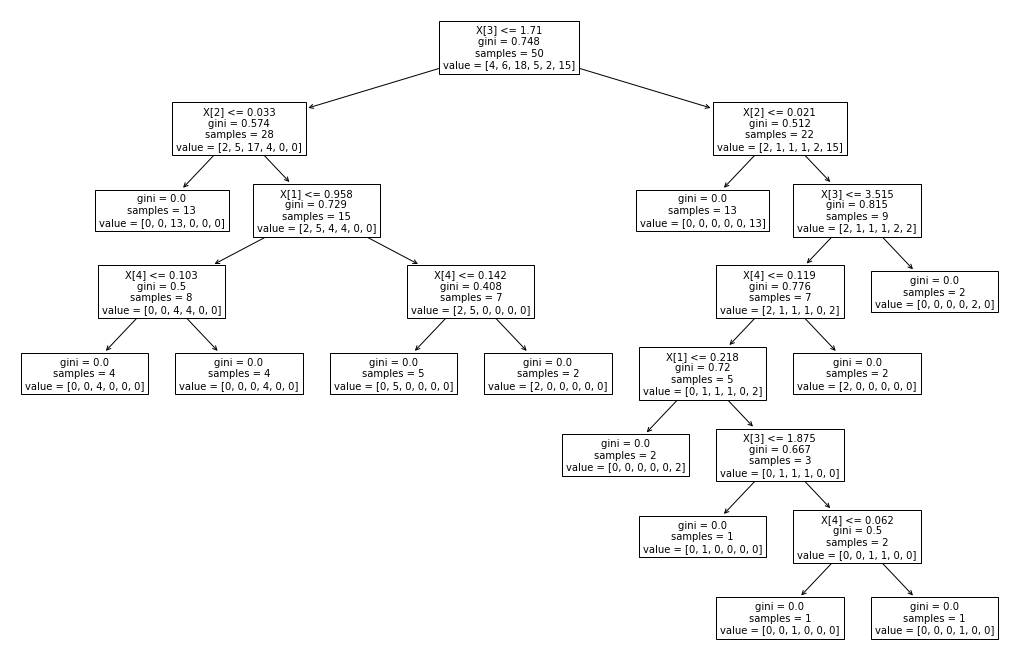

In [151]:
stock_data_features_invest = to_ndarray_invest(stock_data)
print('Investment portfolio')
make_analysis(stock_data_features_invest)

Trading portfolio
Correlation between features
[[ 1.         -0.07899689 -0.01536887 -0.16135915]
 [-0.07899689  1.         -0.11644455 -0.02323772]
 [-0.01536887 -0.11644455  1.         -0.0629366 ]
 [-0.16135915 -0.02323772 -0.0629366   1.        ]]


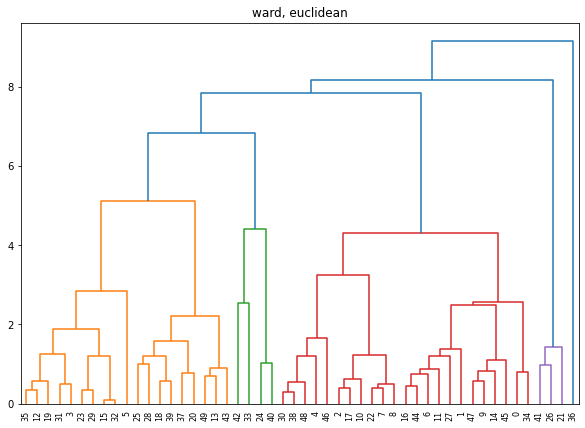

Method ward, Metric euclidean, Number of clusters 2, Silhouette 0.6430819297705733
Method ward, Metric euclidean, Number of clusters 3, Silhouette 0.43757425515336684
Method ward, Metric euclidean, Number of clusters 4, Silhouette 0.2643765594530531
Method ward, Metric euclidean, Number of clusters 5, Silhouette 0.29665507960328363
Method ward, Metric euclidean, Number of clusters 6, Silhouette 0.2760473250163702


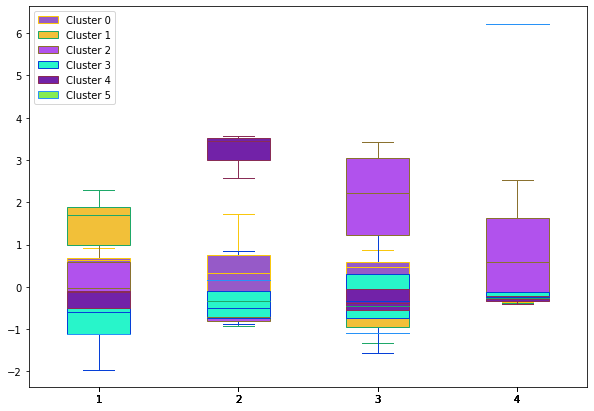

Cluster 1: GEFb AMGN FUL AGCO CTSH ALG RS ATHM ALV BBL
Cluster 2: BGS BWA WBRBY ASTE ERIC NWSA AIMC SAH GFI
Cluster 3: NTTYY T ODC AY
Cluster 4: RDSa TS HNNA ORAN BHE MT RCKY IBA HCMLY AROC ALSN EC NWL BCEI SSL BTI AIR TELNY ACCO B HMC WBA BRDCY
Cluster 5: CEO COKE CBRL
Cluster 6: APOG
Best representatives of clusters
Cluster 0: FUL with coefficient 0.1630306981145665
Cluster 1: GFI with coefficient 0.2445579510361702
Cluster 2: NTTYY with coefficient 0.28753587859154445
Cluster 3: ACCO with coefficient 0.14809180656407547
Cluster 4: CBRL with coefficient 0.477662120644584
Cluster 5: APOG with coefficient 1.0
----------------------------------------------------------------------------------------------------




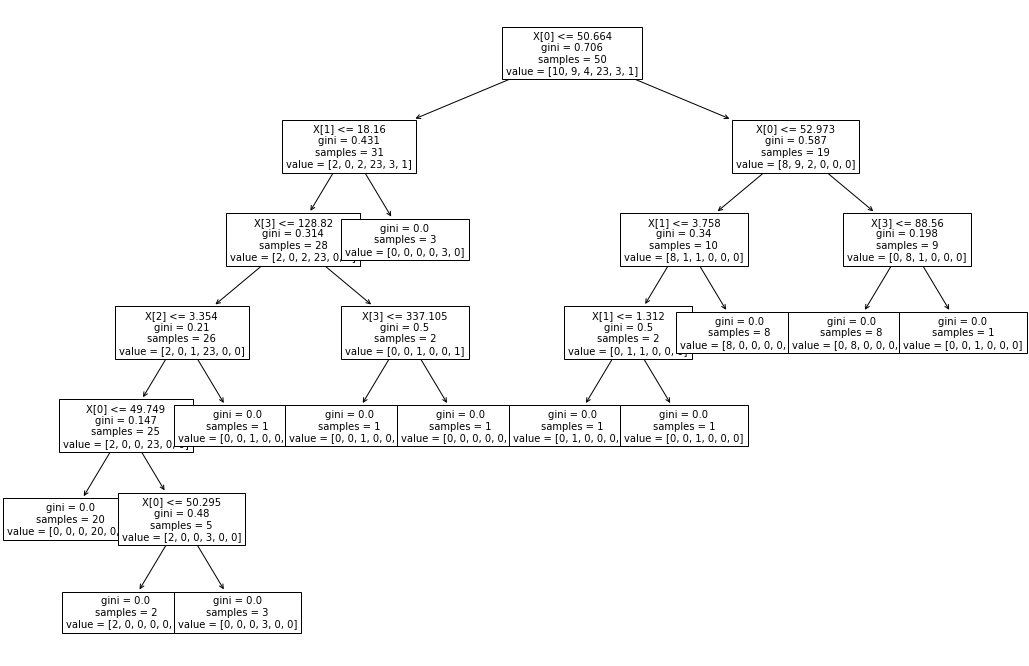

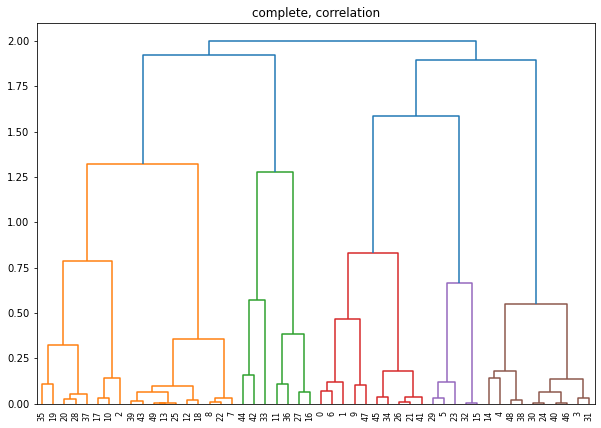

Method complete, Metric correlation, Number of clusters 2, Silhouette 0.42440082048078426
Method complete, Metric correlation, Number of clusters 3, Silhouette 0.39077910569920943
Method complete, Metric correlation, Number of clusters 4, Silhouette 0.4761355470715647
Method complete, Metric correlation, Number of clusters 5, Silhouette 0.504338685323529
Method complete, Metric correlation, Number of clusters 6, Silhouette 0.5064162947515829


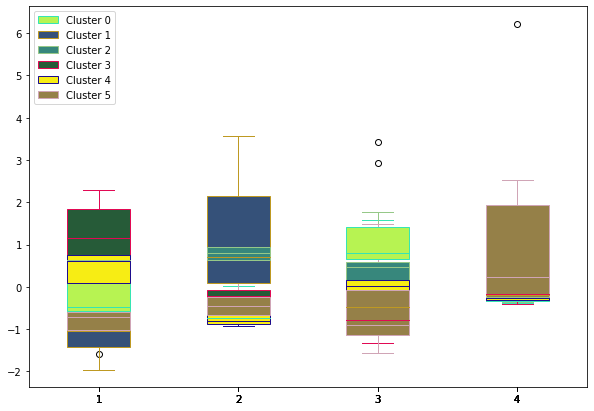

Cluster 1: GEFb ORAN ALSN NTTYY BTI ATHM TELNY ODC HMC BRDCY
Cluster 2: RDSa TS BHE IBA CEO COKE AIR CBRL B WBA
Cluster 3: AMGN AGCO ALG RS ALV
Cluster 4: MT RCKY FUL BGS BWA BCEI ASTE AIMC SAH GFI
Cluster 5: HNNA HCMLY NWL CTSH WBRBY ERIC BBL NWSA
Cluster 6: AROC EC SSL T APOG AY ACCO
Best representatives of clusters
Cluster 0: ORAN with coefficient 0.18030590912730035
Cluster 1: AIR with coefficient 0.23235213931809973
Cluster 2: ALV with coefficient 0.2845366044675276
Cluster 3: GFI with coefficient 0.24349274316718714
Cluster 4: WBRBY with coefficient 0.29573724767706233
Cluster 5: SSL with coefficient 0.2825129353607913


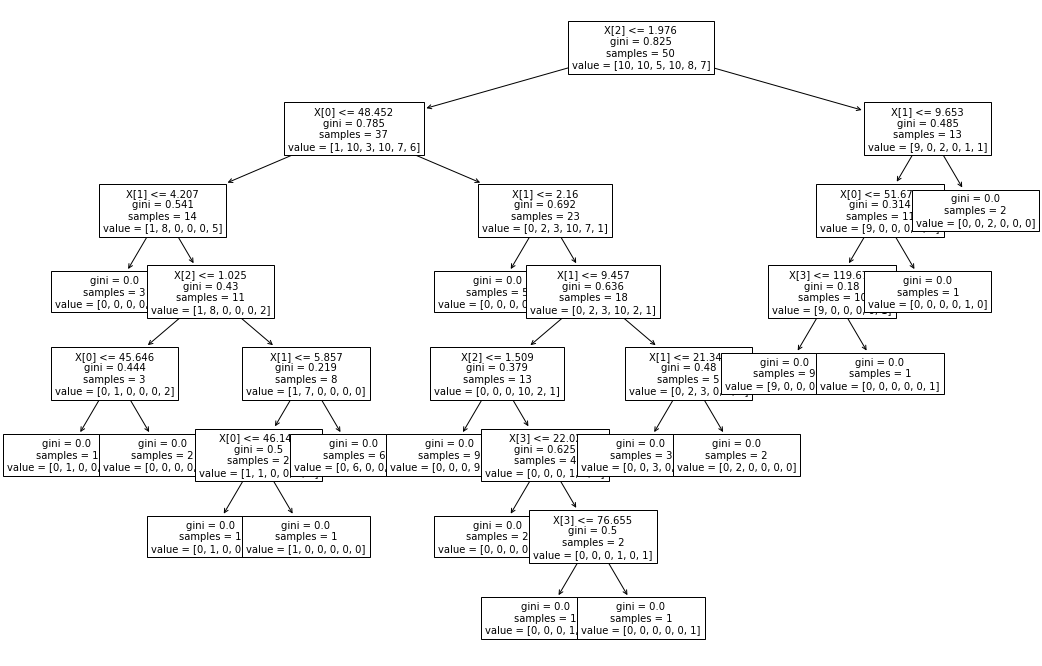

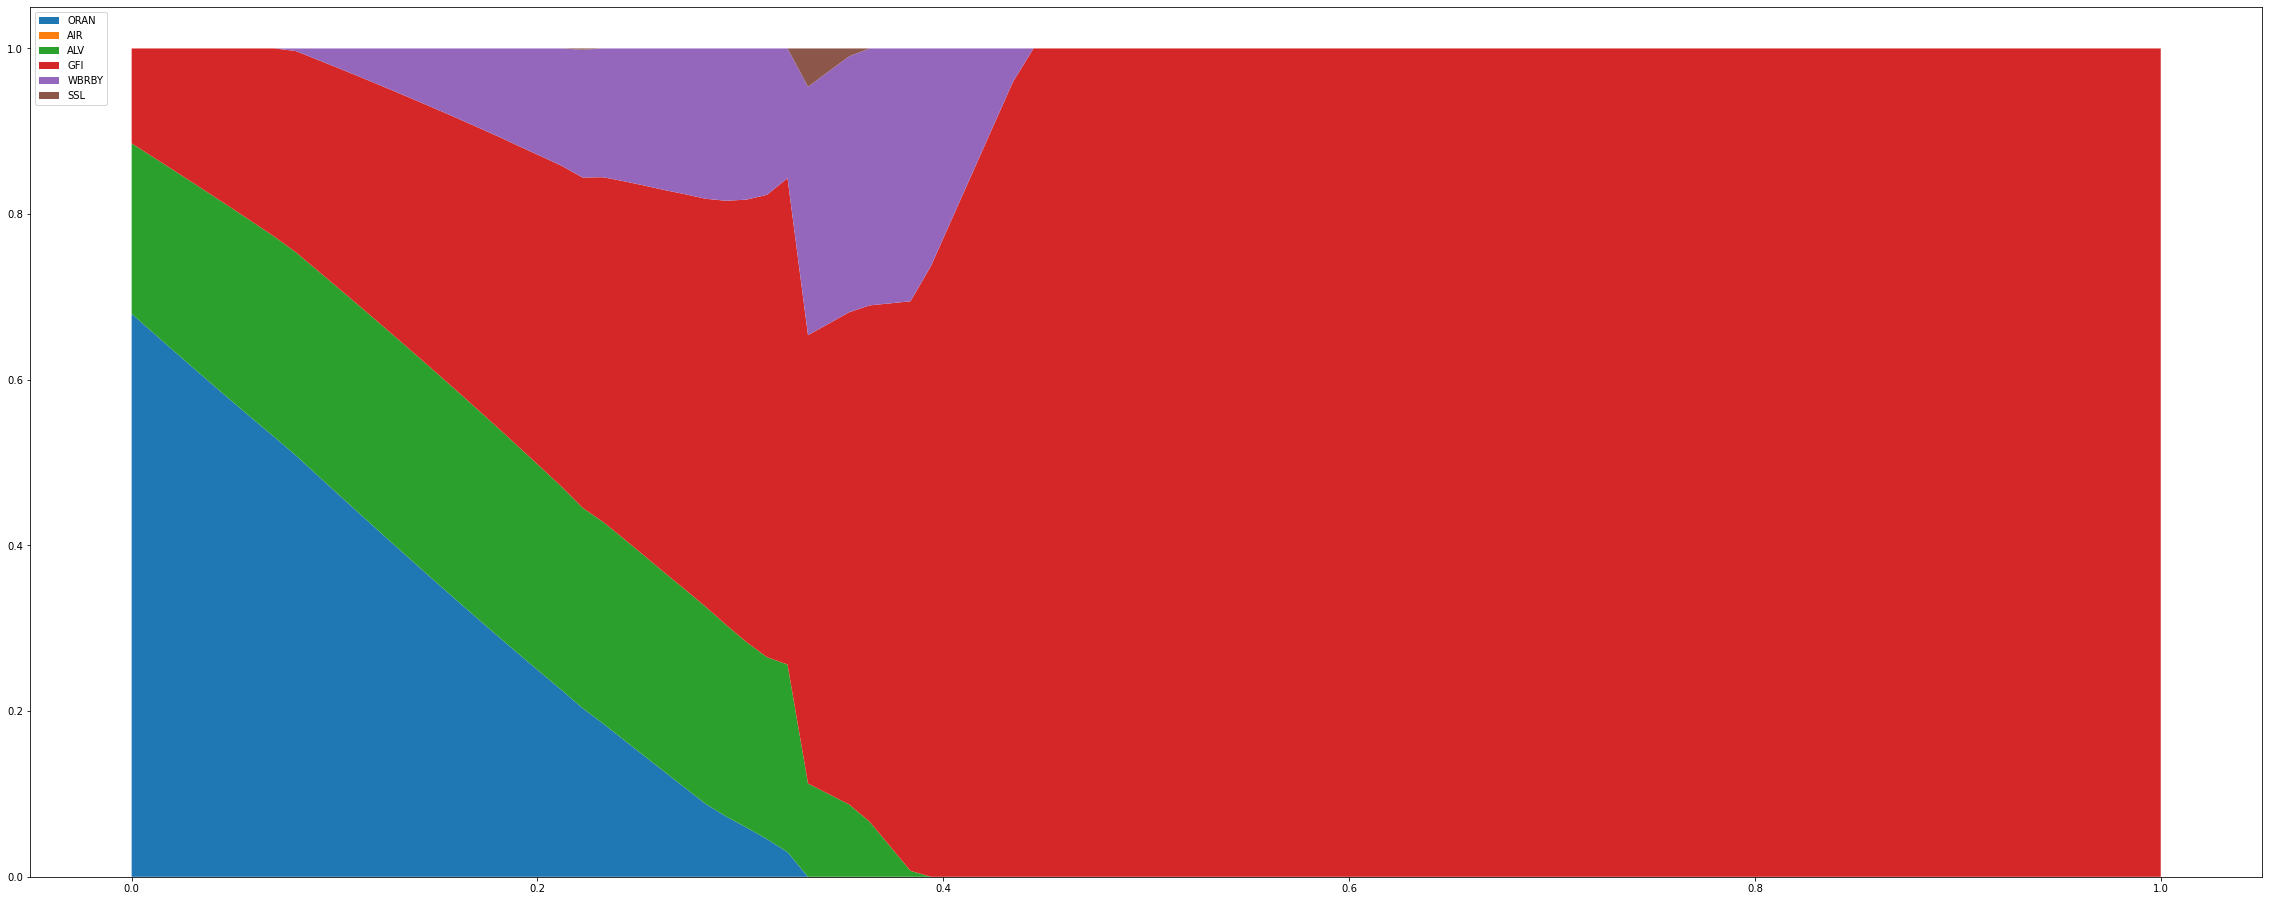

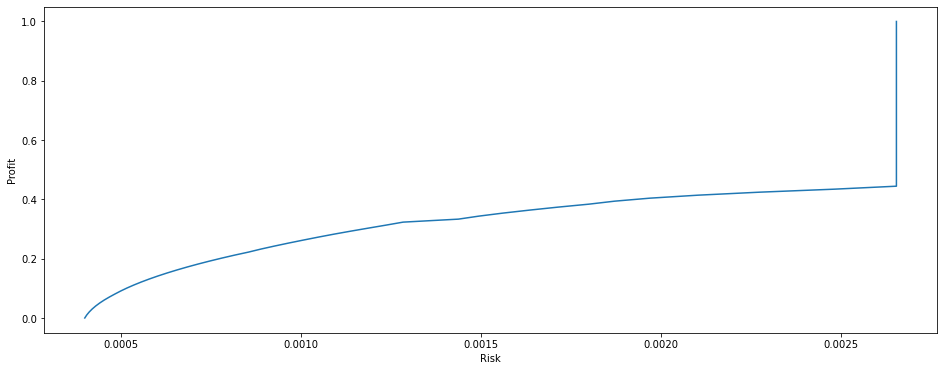

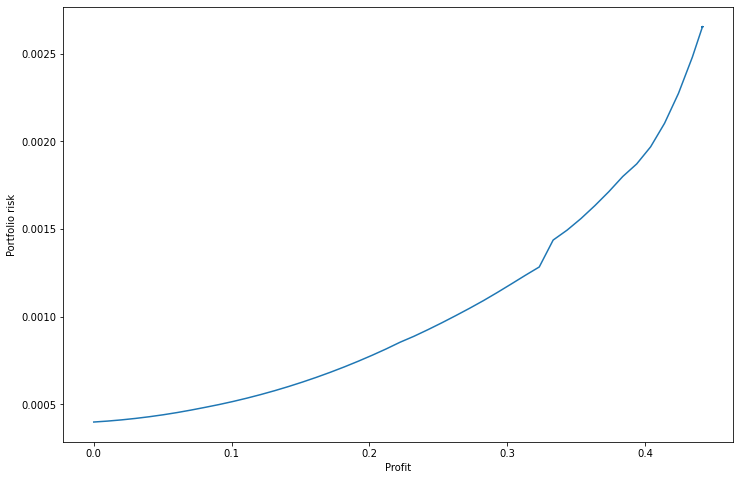

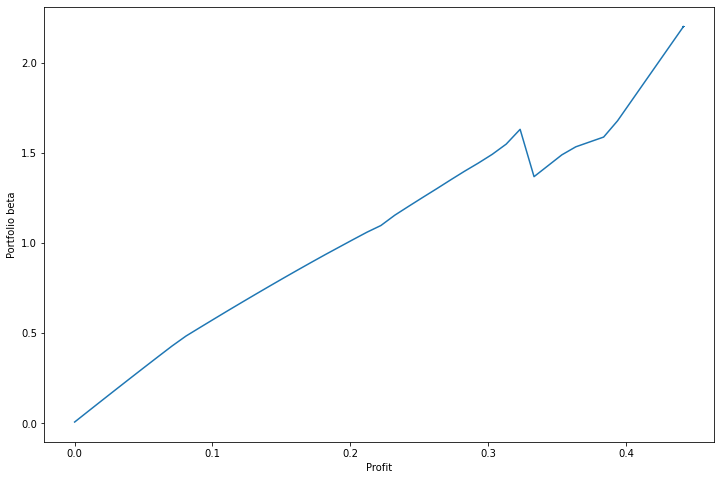

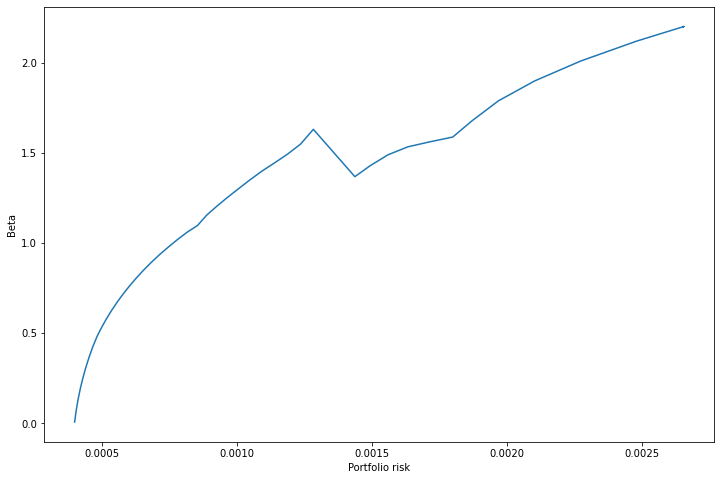

Risk: 0.0004402988317904722
Average daily profit: 0.05050505051379413
Beta: 0.3103097866485436

ORAN: 		0.571824325280608
AIR: 		6.938893903907228e-18
ALV: 		0.23344061939099706
GFI: 		0.19473505532839486
WBRBY: 		2.6020852139652106e-18
SSL: 		0.0


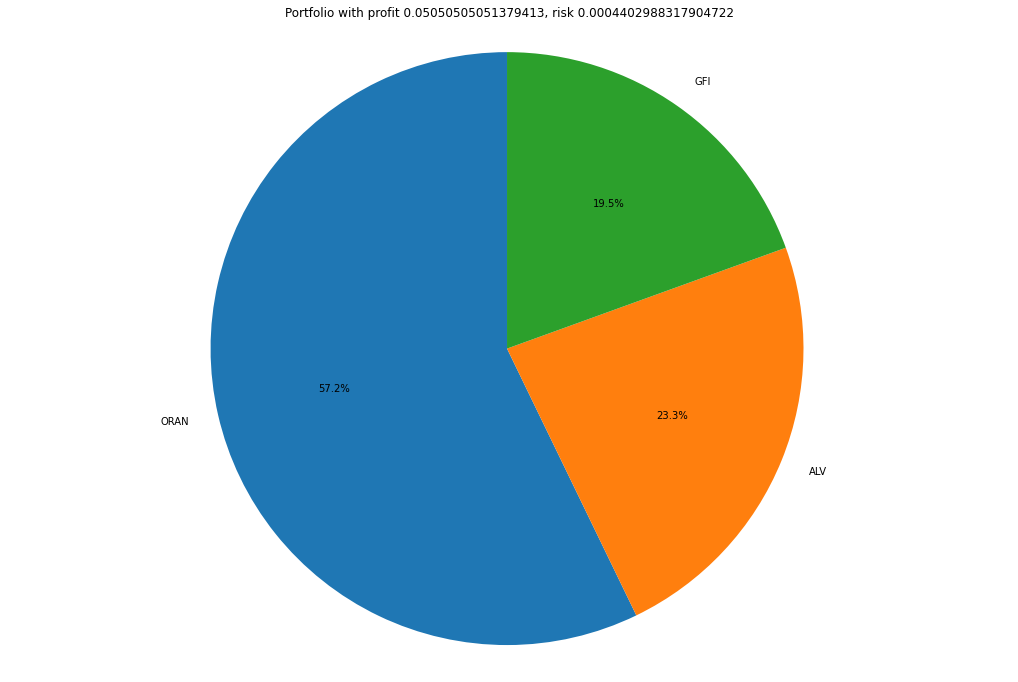

----------------------------------------------------------------------------------------------------




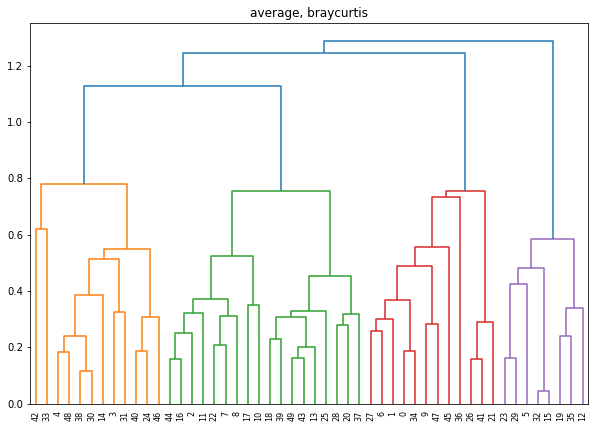

Method average, Metric braycurtis, Number of clusters 2, Silhouette 0.21416644764634626
Method average, Metric braycurtis, Number of clusters 3, Silhouette 0.21187827563646114
Method average, Metric braycurtis, Number of clusters 4, Silhouette 0.33870395814152443
Method average, Metric braycurtis, Number of clusters 5, Silhouette 0.31284445377456005
Method average, Metric braycurtis, Number of clusters 6, Silhouette 0.29274812624928964


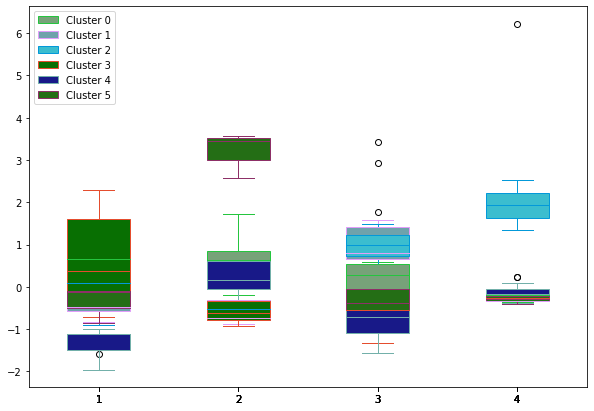

Cluster 1: AMGN FUL AGCO CTSH ALG RS ALV BBL
Cluster 2: GEFb ORAN ALSN NTTYY BTI ATHM TELNY ODC HMC BRDCY
Cluster 3: T AY
Cluster 4: HNNA MT RCKY HCMLY AROC BGS EC NWL BWA WBRBY BCEI ASTE ERIC NWSA AIMC SAH ACCO GFI
Cluster 5: RDSa TS BHE IBA SSL AIR APOG B WBA
Cluster 6: CEO COKE CBRL
Best representatives of clusters
Cluster 0: AGCO with coefficient 0.22525867572939298
Cluster 1: ORAN with coefficient 0.18030590912730035
Cluster 2: AY with coefficient 0.5566698778279723
Cluster 3: ACCO with coefficient 0.127524596407383
Cluster 4: SSL with coefficient 0.39989136880522214
Cluster 5: CBRL with coefficient 0.477662120644584
----------------------------------------------------------------------------------------------------


[[1.         0.44408883 0.65036427]
 [0.3616505  1.         0.65795907]
 [0.58804997 0.73052859 1.        ]]


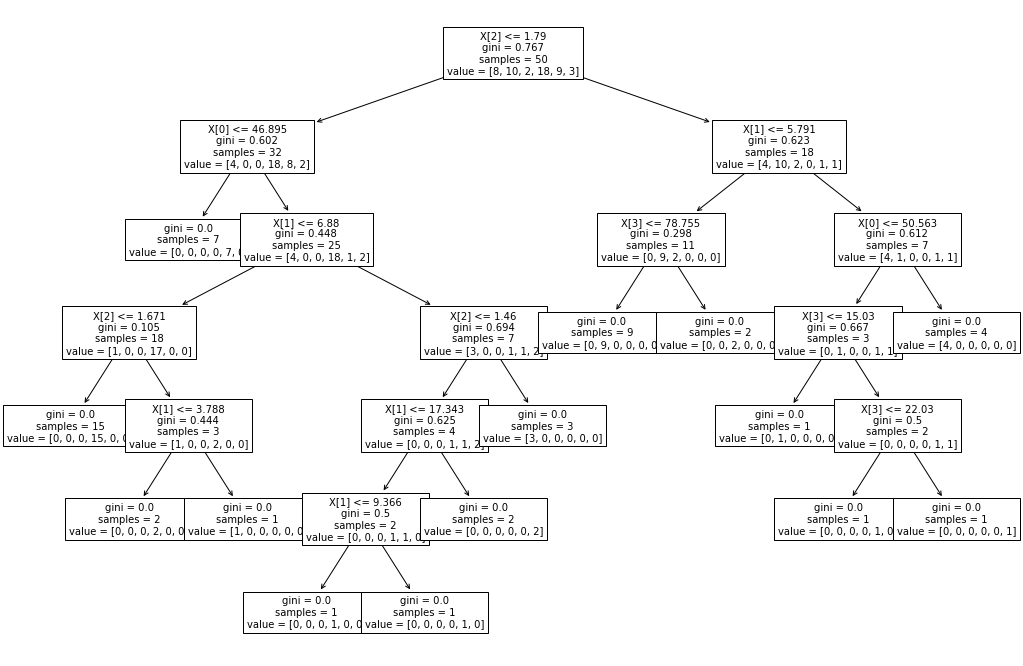

In [152]:
stock_data_features_trade = to_ndarray_trade(stock_data)
print('Trading portfolio')
make_analysis(stock_data_features_trade)